In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from scipy.optimize import curve_fit

data = pd.read_excel (r'C:\Users\callu\Dropbox\03ShOpen1mmGBon_29.38mK_BB3.21.xlsx')

In [4]:
data2 = pd.read_excel (r'C:\Users\callu\Dropbox\University\Year 3\Block 2b\Project\_C04P03ShClosed_44.66mK_BB3.20K.xlsx')

    Most important things to do:
    (1) Fix lists implimentation of findregions or revert to old
    (2) Investigate the y_offset problem -  Maybe use the supercondcting region to find the offset? plot a nice straight line through those bad boys. 
    (3) Make the power read-out more robust
    
    Done: 
    (4) Make a method that calculated R_stray : Do least squares from x=0
    (2) -make animation of threshold changing-
    (5) Made another calc_superconducting so that it can be called before anything else

In [5]:
class TES(object):
    '''
    '''
    # initialise with raw IV data and maybe other params?
    def __init__(self, rawIV, params=0): 
        self.rawIV = [rawIV.iloc[:,0].values , rawIV.iloc[:,1].values]
        self.params = params
        
        self.y_offset = 0
        self.rnn = 0
        
        # Values hard coded (for now) taken from spreadsheet
        self.R_fb = 100099.6
        self.M_ratio = 18.9333333333333
                
        self.gain = 1 / (self.R_fb * self.M_ratio)
        
        self.R_shunt = 0.00389
        self.R_stray = 0.0004539
        #This is calculated by making the graph vertical 
        
    def f(self, x, A, B):
        ''' 
        Function of straight line for optimisation function to find
        coefficients for.
        '''
        return A*x + B
        
    def identify_regions(self, data, threshold):
        '''
        This function accepts a data frame and a threshold to compare the 
        gradient to. Checks either side of data set and identifies regions
        before the spikes.
        Returns a tuple of indices which correspond to the ranges we are 
        interested in
        #TODO Find out what threshold is justified
        '''
        front = 0 
        back = 0 
        self.threshold = threshold
        self.thresh = int((len(data[0])/100) * threshold)
        print('Number of disregarded entries: '+ str(self.thresh))
        grad = np.gradient(data[1]) #Gradient of the Voltages
        for i in range(len(data[1])): 
            if grad[i] <= 0:#Check from the start until grad 
                front = i - self.thresh         #hits the threshold then store index
                break
        for n in range(len(data[1])):
            if grad[-n] <= 0:
                back = len(data) - n + self.thresh 
                break
        return front , back

    # A,B = curve_fit(f, data['bias'], data['V fb (V)'])[0]
    def fitLine(self, inputdata, region):
        ''' 
        Accepts a data frame and a tuple of indices. These are then used 
        to fit a straight line to the straight regions and plots the
        line with the data in the frame. 
        Returns nothing.
        #TODO Generalise!!
        '''
        front , back = region # Unpack data ranges from region

        firstx = inputdata[0][0]
        lastx = inputdata[0][-1]
        

        xvals = np.linspace(firstx, lastx)

        #Slice the data in the frame and store in an array 
        yvals1 = inputdata[1][:front]
        yvals2 = inputdata[1][back:]
        lineDataY = np.append(yvals1, yvals2)
        
        xvals1 = inputdata[0][:front]
        xvals2 = inputdata[0][back:]

        lineDataX = np.append(xvals1, xvals2)
        print("Regions")
        print(front, back)
        #print("LinedataX : " + str(lineDataX))

        #fit the sliced data to a line
        C, D = curve_fit(self.f, lineDataX, lineDataY)[0]

        return C , D , xvals
    
    def calc_y_offset(self, thresholdPercentage):
        '''
        Input: Threshold percentage (int)
        OutPut: D (float)
        '''
        ranges = self.identify_regions(self.rawIV, thresholdPercentage)
        C, D , xvals = self.fitLine(self.rawIV, ranges)
        self.y_offset = D
        #print("y offset: " + str(D))
        self.rawXvals = xvals
        
    def calc_I_TES(self, tweak=1):
        '''
        Generate I_tes (array) data from tweak(float), y_offset (float)
        , gain (float).
        
        tweaks not yet used
        '''
        #TODO generate 
        self.I_TES = [(entry - self.y_offset) * 10**6 * self.gain for entry in (self.rawIV[1])]
        
    def calc_V_bias(self, tweak=1):
        '''
        Generates B_bias data
        '''
        self.V_bias = []
        for index in range(len(self.rawIV[0])):
            self.V_bias.append((self.rawIV[0][index] * self.R_shunt) - (self.I_TES[index]*(self.R_shunt + self.R_stray)))
        
    def plotIV(self):
        '''
        
        '''
        #plt.plot(self.V_bias, self.I_TES)
        analysed_IV = [self.V_bias, self.I_TES]
        regions = self.identify_regions(analysed_IV, self.threshold)

        C, D , Axvals = self.fitLine(analysed_IV, regions)
        
        self.rnn = 1/C
        
        fig, ax = plt.subplots()
        
        plt.plot(Axvals, self.f(Axvals, C , D), label='Load Line')
        #plt.axhline(y=0)
        #plt.axvline(x=0)
        plt.grid()
        plt.plot(self.V_bias, self.I_TES, label='TES IV')
        ax.set_xlabel("Voltage (mV)")
        ax.set_ylabel("TES Current (mA)")
        #plt.title("Calibrated IV Curve")
        ax.legend()
        #plt.plot(lineDataX, lineDataY)
        
    def calc_P_TES(self):
        self.P_TES = [self.I_TES[index] * self.V_bias[index] for index in range(len(self.I_TES))]

    def plotPV(self):
        fig, ax = plt.subplots()
        plt.grid()
        plt.plot(self.V_bias, self.P_TES, label='TES PV')
        plt.title("Power Curve")
        ax.set_xlabel("Voltage (mV)")
        ax.set_ylabel("TES Power (fW)")
        
        if self.calc_superconducting():
            readout = self.constLine(self.P_TES, (max(self.P_TES)/500))
            plt.plot(self.V_bias, [readout for entry in self.V_bias], label=readout)
        
        plt.legend()
        

    def constLine(self, data, margin):
        '''
        Trying to optimise a line of y = const to read off the power from the graph.
        Accepts a set of data (power values) and a step size, which doubles as the margin.
        Returns the y value which corresponds to the most values from the power graph.

        #TODO make more robust. maybe make it find the largest x range rather than just hits

        This is currently a niave implementation  but it works under the assumption that there will be 
        either uniform readings or higher concentration around 0. Currently -ve values of P are disregarded to 
        '''
        ys = []
        counts = []
        y = 0
        while y < max(data):
            y1 = y - margin
            y2 = y + margin
            count = 0
            for entry in data:
                if entry > 0 and entry > y1 and entry < y2:
                    count += 1
            counts.append(count)
            ys.append(y)
            y += margin
        npcounts = np.array(counts)
        ind = np.argmax(npcounts)
        return ys[ind]
    
    def calc_R_TES(self):
        self.R_TES = [self.V_bias[i] / self.I_TES[i] for i in range(len(self.V_bias))]

    def plotPR(self):
        fig, ax = plt.subplots()
        plt.grid()
        plt.plot(self.R_TES, self.P_TES, label='TES PR')
        plt.title("Power vs Resistance Curve")
        ax.set_xlabel("TES Resistance (ohm)")
        ax.set_ylabel("TES Power (fW)")
        
        if self.calc_superconducting():
            readout = self.constLine(self.P_TES, (max(self.P_TES)/500))
            plt.plot(self.R_TES, [readout for entry in self.R_TES], label=readout)

        plt.legend()
        
    def calc_superconducting(self):
        differences = []
        
        for idx in range(len(self.V_bias) - 1):
            differences.append(self.I_TES[idx] - self.I_TES[idx + 1])
        rangeI = max(self.I_TES) - min(self.I_TES)
        if max(differences) >= rangeI / 10:
            self.superconducting = True
        else:
            self.superconducting = False
            
        return self.superconducting
    
    def calc_superconducting2(self):
        grad = np.gradient(self.rawIV[1], self.rawIV[0])
        print(max(grad) , min(grad))
        if max(grad) > 3*(sum(grad)/len(grad)) and abs(min(grad)) > 5*(sum(grad)/len(grad)):
            self.superconducting2 = True
        else:
            self.superconducting2 = False
    
    
    
    def calc_R_stray(self, start = 0 , end = 0.001, step = 0.0000001, threshold = 0.001):
        '''
        Go through a range of R_strays and find the one which gives the least error when compared to the yaxis. 
        Then set this as self.rstray
        Inputs:
        start, end and step : (floats)
        used in np.arange function that searches for R_stray. So the precision of R_stray value will depend on these.
        threshold: (float)
        The margin around the axis which you want to consider for catching points. 
        '''
        #Initialise lists for storage of results
        resists = []
        scores = []

        for resist in np.arange(start, end, step):
            V_bias = []
            for index in range(len(TEStr.rawIV[0])):
                        V_bias.append((TEStr.rawIV[0][index] * R_shunt) - (TEStr.I_TES[index]*(R_shunt + resist)))
            score = 0
            for i in range(len(V_bias)):
                if abs(V_bias[i]) <= threshold:
                    score += abs(V_bias[i])**2

            # Scores are errors, make a list so we can find the resistance that has lowest error
            scores.append(score)
            resists.append(resist)

        self.R_stray = resists[np.argmin(scores)]
        
    def calc_all(self):
        self.calc_y_offset(20)
        self.calc_I_TES()
        self.calc_V_bias()
        self.calc_superconducting()
        self.calc_P_TES()
        self.calc_R_TES()
        
        
        
    ##################################################################################################
    ## Possible future functions
    def smooth_IV():
        #TODO
        ''' Maybe a function to smooth noisy data before we find the 
        y offset. 
        Inputs: rawIV (or just use self?)
        Outputs: stores smoothRawIV in self
        '''
        pass
    
    def find_threshold():
        '''
        Will find the most optimal threshold to use for the region finding
        '''
        
        pass 

In [6]:
TESsuper = TES(data)
TESsuper.calc_all()
TESnotsuper = TES(data2)
TESnotsuper.calc_all()

TESsuper.calc_superconducting2()
print(TESsuper.superconducting2)

TESnotsuper.calc_superconducting2()
print(TESnotsuper.superconducting2)

Number of disregarded entries: 69
Regions
39 -38
Number of disregarded entries: 69
Regions
0 0
1.868891408303389 -12.193802312835974
True
0.07739913381162067 0.06531901224114023
False


In [7]:
for i in range(2):
    print(i)
    TESt = TES(data)
    TESt.calc_y_offset(i)
    print(TESt.y_offset)
    TESt.calc_I_TES()
    TESt.calc_V_bias()
    #TESt.plotIV()
    plt.show()
    print(TESt.rnn)

0
Number of disregarded entries: 0
Regions
108 -107
-0.0007959675014361714
0
1
Number of disregarded entries: 3
Regions
105 -104
-0.0007274206054597648
0


Biggest conceptual problem is how to reliably choose a threshold.
What to do next:
Find a way of finding the best threshold and investigate cutting off the front and back too.
Doing the list thing clearly screwed up generating the regions.

Number of disregarded entries: 69
Regions
39 -38
Number of disregarded entries: 69
Regions
39 -38
0.005
Number of disregarded entries: 69
Regions
39 -38
Number of disregarded entries: 69
Regions
39 -38
0.004539


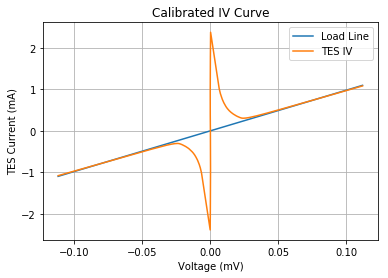

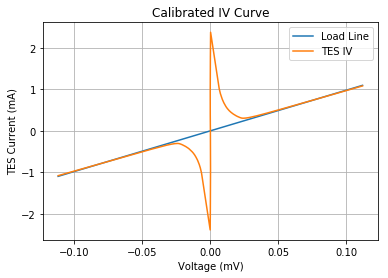

In [8]:
TESt = TES(data)
TESt.r_stray = 0.005
TESt.calc_all()
TESt.plotIV()
print(TESt.r_stray)


TESt.r_stray = 0.004539
TESt.calc_all()
TESt.plotIV()
print(TESt.r_stray)

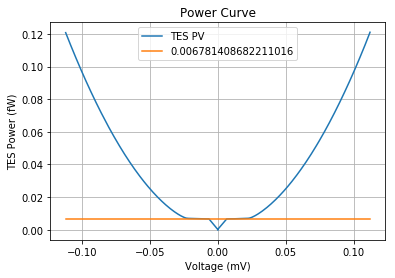

In [9]:
TESt.calc_P_TES()
TESt.plotPV()

    Things to do:
    (0) Find which thresholds work best, maybe write a function to pick the best?
    Ok, so the problem is that there are many more entries towards the transition than out at the edges. In order to get a consistant result a better cutoff needs to be found. Maybe use only values that fall within an x-range rather than just dumping a percentage of the data. This would be more robust to changing amounts of data. 
    (i)Find the average of the first and last 30% of x-range entries then use these points to fit the straight line. 
    (ii) Find where the value where the gradient deviates from its original by some margin and use this as the cutoff
   
    
    --(1) Try test cases where there is no superconductivity and find a way to deal with those. (look for --ve to ++ve in data or use a nueral net for the fun of it)
    Turns out it analyses the data fine. Does produce readoff lines when it shouldnt though. Made a test to see if superconducting. Seems to work on simple cases. --
    
    (2) Re-check the gradient of the raw data. The gradient doesn't start constant, so maybe snip some off the front too? Does it make a difference?
    
    See problem (0)
    
    (3) I'm currently storing data in dataframes and ranges, as well as standard lists. This should be standardised. Also prefer np arrays over lists.
    Ok using pure vanilla lists is actually faster as otherwise I'm just converting to np for no reason. The code is also a lot easier to read when they are normal lists. Output could still be made into a dataframe, however. 
    
    (4) Look at the perl scipts
    (5) Build in noise resistance, smooth the curve?
    (6) Find efficiency improvements 

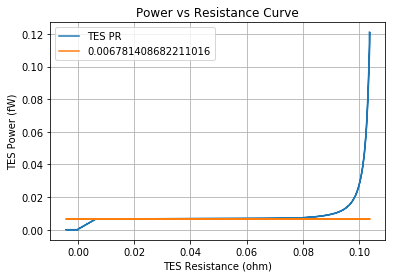

In [10]:
TESt.calc_R_TES()
TESt.plotPR()

Number of disregarded entries: 381
Regions
0 0
-0.0001982451649702751
Number of disregarded entries: 381
Regions
0 0


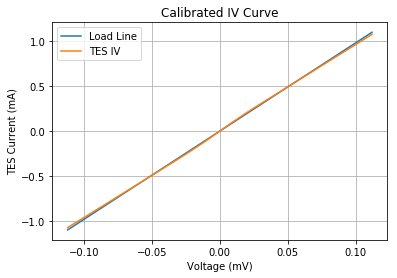

In [11]:
TESt2 = TES(data2)

TESt2.calc_y_offset(110)
print(TESt2.y_offset)
TESt2.calc_I_TES()
TESt2.calc_V_bias()
TESt2.plotIV()

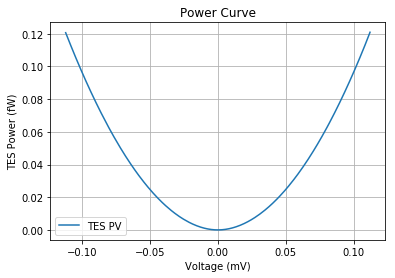

In [12]:
TESt2.calc_P_TES()
TESt2.plotPV()

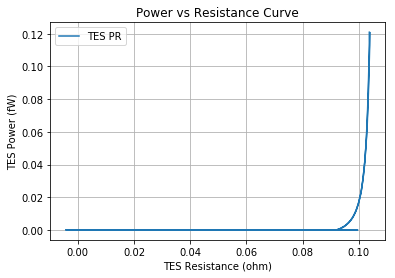

In [13]:
TESt2.calc_R_TES()
TESt2.plotPR()

In [14]:
TESt.calc_superconducting()
print(TESt.calc_superconducting())
print(TESt2.calc_superconducting())
print(TESt.superconducting == TESt2.superconducting)

True
False
False


In [15]:
TESt.calc_superconducting2()
TESt2.calc_superconducting2()
print(TESt.superconducting2)
print(TESt2.superconducting2)
print(TESt.superconducting2 == TESt2.superconducting2)

1.868891408303389 -12.193802312835974
0.07739913381162067 0.06531901224114023
True
False
False


Number of disregarded entries: 69
Regions
39 -38


array([-2.04538716, -1.97919251, -1.91426959, -1.84782913, -1.78138867,
       -1.71526882, -1.64871081, -1.58248409, -1.51606501, -1.48354477,
       -1.4499131 , -1.4176066 , -1.38516117, -1.37190941, -1.35852941,
       -1.34554483, -1.33234651, -1.31899857, -1.30590712, -1.29260193,
       -1.27923262, -1.26613048, -1.25285735, -1.23962697, -1.22664238,
       -1.213412  , -1.20040604, -1.18715429, -1.17393459, -1.16082176,
       -1.14766619, -1.13451062, -1.12137642, -1.10804985, -1.09501183,
       -1.08202725, -1.06879687, -1.05582084, -1.04275396, -1.02952892,
       -1.01631778, -1.00332144, -0.99017441, -0.9771022 , -0.96413044,
       -0.95110525, -0.93794967, -0.92514783, -0.91223165, -0.89921287,
       -0.8874872 , -0.87452292, -0.86754972, -0.86183543, -0.85493169,
       -0.84905497, -0.84193108, -0.83621038, -0.82916237, -0.8232803 ,
       -0.81644176, -0.81077236, -0.8038216 , -0.79808594, -0.79111915,
       -0.7852296 , -0.77861227, -0.77277188, -0.76605409, -0.76

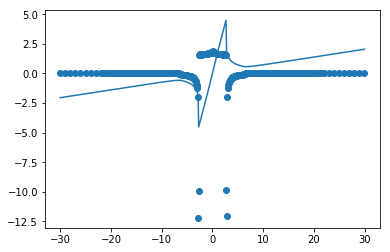

In [29]:
TEStr = TES(data)

TEStr.calc_all()


plt.scatter(TEStr.rawIV[0], np.gradient(TEStr.rawIV[1], TEStr.rawIV[0]))
plt.plot(TEStr.rawIV[0], TEStr.rawIV[1] )

TEStr.rawIV[1]

Number of disregarded entries: 69
Regions
0 0


array([-2.04170018e+00, -1.97559102e+00, -1.91034750e+00, -1.84401391e+00,
       -1.77726353e+00, -1.71089788e+00, -1.64425437e+00, -1.57755743e+00,
       -1.51082843e+00, -1.47815857e+00, -1.44431316e+00, -1.41158987e+00,
       -1.37906964e+00, -1.36570032e+00, -1.35217071e+00, -1.33896170e+00,
       -1.32562445e+00, -1.31222308e+00, -1.29894995e+00, -1.28556995e+00,
       -1.27215789e+00, -1.25899163e+00, -1.24560094e+00, -1.23229575e+00,
       -1.21907606e+00, -1.20552507e+00, -1.19251911e+00, -1.17890400e+00,
       -1.16567362e+00, -1.15234705e+00, -1.13893499e+00, -1.12545881e+00,
       -1.11220706e+00, -1.09875225e+00, -1.08535088e+00, -1.07220599e+00,
       -1.05877897e+00, -1.04535302e+00, -1.03208844e+00, -1.01868279e+00,
       -1.00511898e+00, -9.92043553e-01, -9.78436992e-01, -9.65000353e-01,
       -9.51688750e-01, -9.38248905e-01, -9.24634863e-01, -9.11429060e-01,
       -8.98002039e-01, -8.84489523e-01, -8.72372716e-01, -8.59030121e-01,
       -8.51508681e-01, -

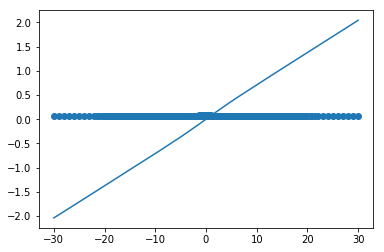

In [17]:
TEStr = TES(data2)

TEStr.calc_all()


plt.scatter(TEStr.rawIV[0], np.gradient(TEStr.rawIV[1], TEStr.rawIV[0]))
plt.plot(TEStr.rawIV[0], TEStr.rawIV[1] )

TEStr.rawIV[1]

Max +ve gradient at:
11.066671776564938
0.00099999
Max -ve gradient at:
9.176650214470783


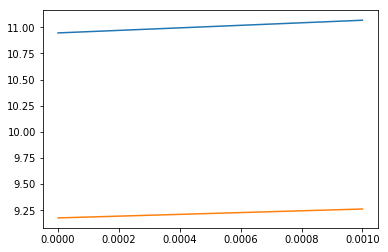

In [18]:
R_fb = 100099.6
R_shunt = 0.00389

# trying to minimise the x value difference between the points at the critical part of the transition

file = open('max_grad_log.txt', 'a')

pos_gradients = []
neg_gradients = []
resists = []
averages=[]
i=0
start = 0
end = 0.001
step = 0.00000001
for resist in np.arange(start,end,step):
    #plt.figure(figsize=(10,10))
    #plt.grid()
    #plt.axis([-.1,.1,-3,3])
    V_bias = []
    for index in range(len(TEStr.rawIV[0])):
                V_bias.append((TEStr.rawIV[0][index] * R_shunt) - (TEStr.I_TES[index]*(R_shunt + resist)))
            
    pos_gradients.append(max(np.gradient(TEStr.I_TES, V_bias)))
    neg_gradients.append(min(np.gradient(TEStr.I_TES, V_bias)))
    averages.append(sum(np.gradient(TEStr.I_TES, V_bias)/len(TEStr.I_TES)))
    
    
    resists.append(resist)
    #print(resist)
    grad = np.gradient(TEStr.I_TES, V_bias)
    #print(grad)
    #if i == 7 or i == 5:
        #print(V_bias)
        #plt.scatter(V_bias, grad, label=resist)
        #plt.show()
    resist2 = str(resist) + "IV"
    #plt.scatter(V_bias, TEStr.I_TES, label=resist2)
    #if i == 7 or i == 5:
        #plt.scatter(V_bias, TEStr.I_TES)
        #plt.show()
      #  plt.show()
    #plt.show()
        #plt.plot(TEStr.I_TES, np.gradient(V_bias, TEStr.I_TES))
    #plt.plot(V_bias, TEStr.I_TES )
    name = 'plot' + str(i) + 'R_stray' + str(resist) + '.png'
    #plt.title(round(resist, 5))
    #plt.savefig(name)
    #plt.show()
    i += 1


#plt.plot(TEStr.rawIV[0], np.gradient(TEStr.rawIV[1], TEStr.rawIV[0]))
#plt.plot(TEStr.rawIV[0], TEStr.rawIV[1] )

def find_transition(pos_gradients, neg_gradients):
    
    for i in range(len(pos_gradients)):
        if abs(pos_gradients[i]) < abs(neg_gradients[i]):
            return i
        
plt.plot(resists, pos_gradients)
plt.plot(resists, neg_gradients)
plt.savefig(str(step))
#print(find_transition(pos_gradients, neg_gradients))
print("Max +ve gradient at:")
print(max(pos_gradients))
file.write("\n------------------------------------------\n")
file.write(str(step))
file.write('\n')
file.write(str(max(pos_gradients)))
file.write('\n')
file.write(str(resists[np.argmax(pos_gradients)]))
print(resists[np.argmax(pos_gradients)])
print("Max -ve gradient at:")
print(min(neg_gradients))
#print(resists[np.argmin(neg_gradients)])
#print(averages)


file.close()


    This method is not reliable at all for finding R_stray. ie taking gradients of the data and tryint to maximise it. Instead I'll try doing least squares with the y axis (x=0).

In [32]:
start = 0
end = 0.001
step = 0.000001

counts = []
resists = []
threshold = 0.001
points = []
Is = []
scores = []

Voltages = []

file = open('min_score_log.txt', 'a')

for resist in np.arange(start,end,step):
    #plt.figure(figsize=(10,10))
    #plt.grid()
    #plt.axis([-.1,.1,-3,3])
    V_bias = []
    count = 0
    for index in range(len(TEStr.rawIV[0])):
                V_bias.append((TEStr.rawIV[0][index] * R_shunt) - (TEStr.I_TES[index]*(R_shunt + resist)))
    entriesV = []
    entriesI = []
    score = 0
    for i in range(len(V_bias)):
        if abs(V_bias[i]) <= threshold:
            count += 1
            entriesV.append(V_bias[i])
            entriesI.append(TEStr.I_TES[i])
            score += abs(V_bias[i])**2
    Voltages.append(V_bias)
    scores.append(score)
    counts.append(count)
    resists.append(resist)
    points.append(entriesV)
    Is.append(entriesI)


file.write("\n------------------------------------------\n")
file.write(str(step))
file.write('\n')
file.write(str(resists[np.argmin(scores)]))
file.write('\n')

1

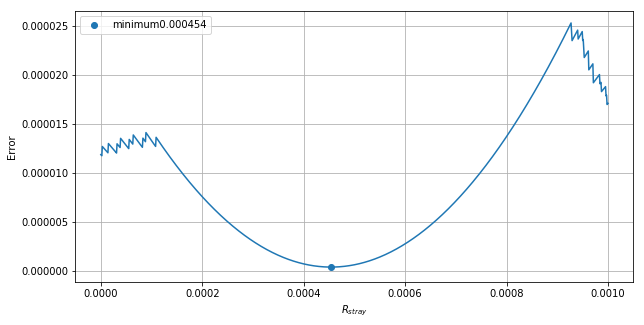

No handles with labels found to put in legend.


0.000454
Number of disregarded entries: 69
Regions
39 -38
4.177513529783155e-07
Most Points within threshold
Number of disregarded entries: 69
Regions
39 -38


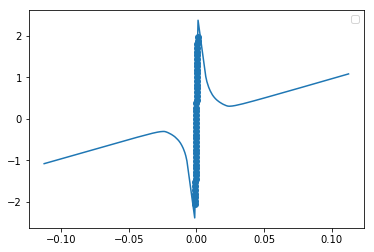

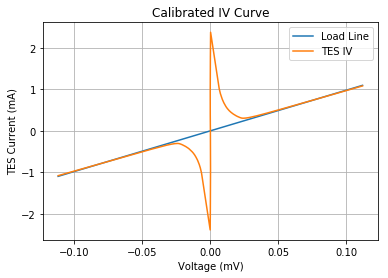

<Figure size 432x288 with 0 Axes>

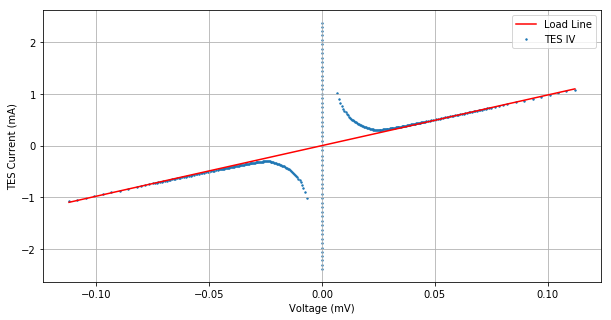

In [54]:
idx = np.argmin(scores)
plt.figure(figsize=(10,5))
plt.plot(resists, scores)
plt.scatter(resists[idx],scores[idx], label='minimum' + str(resists[idx]))
plt.xlabel("$R_{stray}$")
plt.ylabel("Error")
plt.grid()
plt.legend()
plt.savefig(str(step) + '-score.png') 
plt.show()
print(resists[np.argmin(scores)])
plt.scatter(points[np.argmin(score)], Is[np.argmin(score)])
plt.legend()
plt.plot(Voltages[np.argmin(score)], TEStr.I_TES)
TEStr.plotIV()
print(min(scores))
print("Most Points within threshold")

analysed_IV = [TEStr.V_bias, TEStr.I_TES]
regions = TEStr.identify_regions(analysed_IV, TEStr.threshold)

C, D , Axvals = TEStr.fitLine(analysed_IV, regions)

TEStr.rnn = 1/C
plt.figure()
fig, ax = plt.subplots(figsize=(10,5))

plt.plot(Axvals, TEStr.f(Axvals, C , D), label='Load Line',color='r')

#plt.axhline(y=0)
#plt.axvline(x=0)
plt.grid()
plt.scatter(TEStr.V_bias, TEStr.I_TES, label='TES IV',s=2)
#plt.scatter(points[np.argmin(score)], Is[np.argmin(score)],label='Superconducting Region', color='r',s=4)
ax.set_xlabel("Voltage (mV)")
ax.set_ylabel("TES Current (mA)")
#plt.title("Calibrated IV Curve")
ax.legend()
#plt.plot(lineDataX, lineDataY)

    The difference between this result and the one in the sheet may be due to an x-axis offset? The line could be wiggled around 0 and could be used to find the offset. We want to minimise the error, so see if the error goes up or down when it is wiggled. 

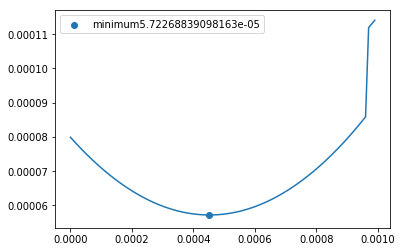

0.00045000000000000004


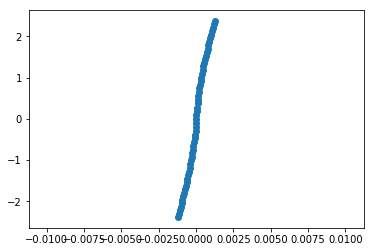

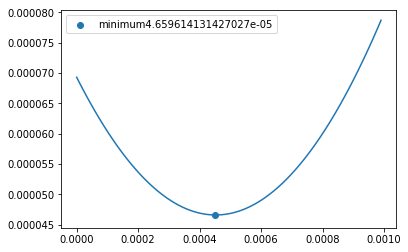

0.00045000000000000004


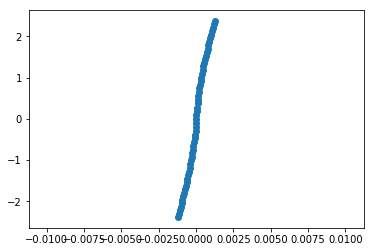

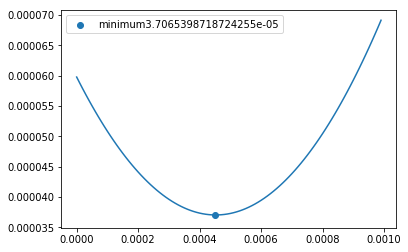

0.00045000000000000004


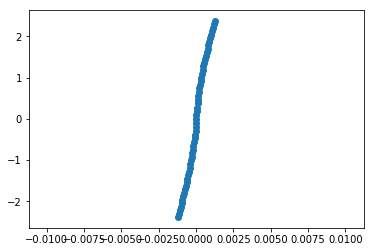

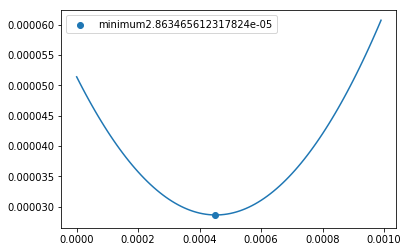

0.00045000000000000004


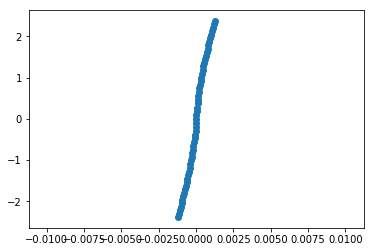

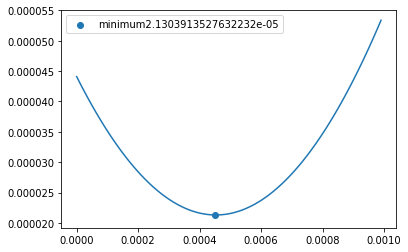

0.00045000000000000004


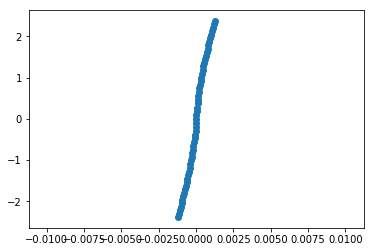

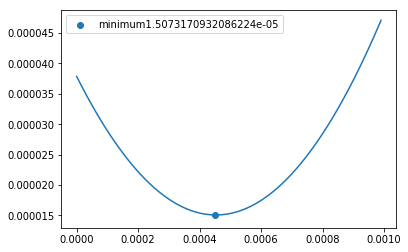

0.00045000000000000004


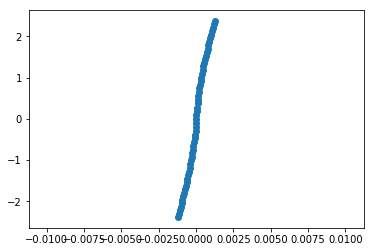

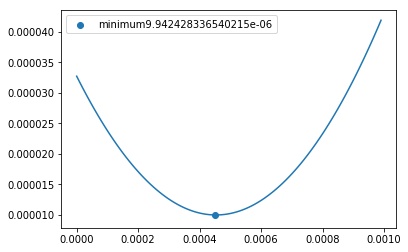

0.00045000000000000004


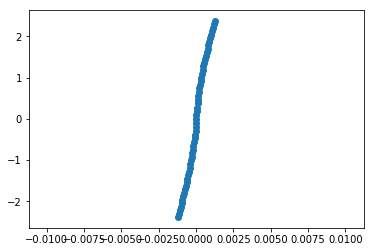

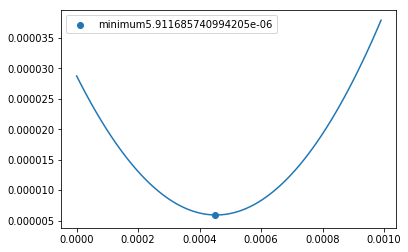

0.00045000000000000004


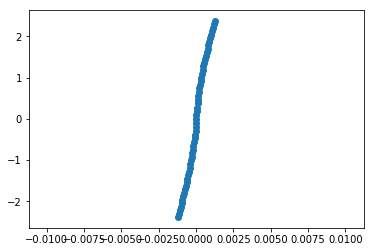

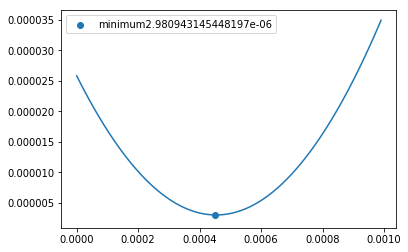

0.00045000000000000004


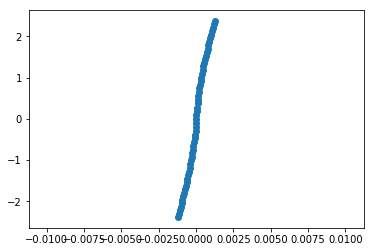

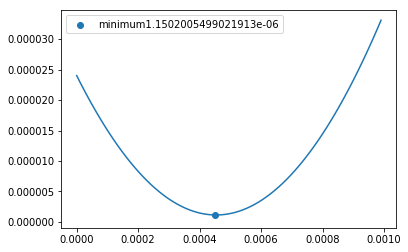

0.00045000000000000004


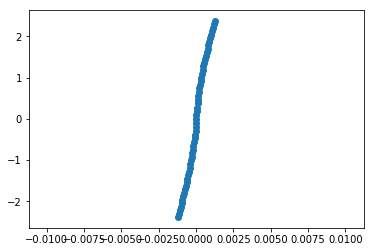

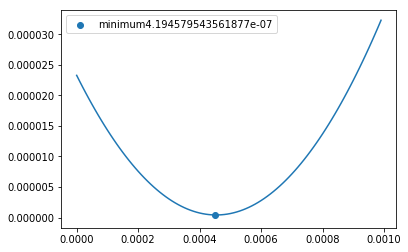

0.00045000000000000004


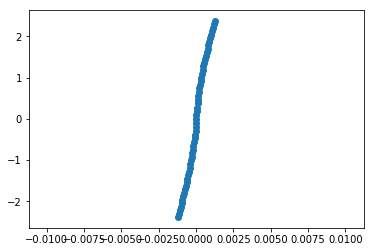

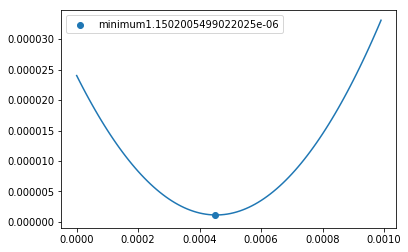

0.00045000000000000004


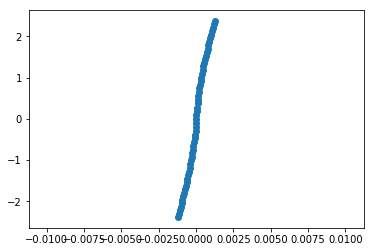

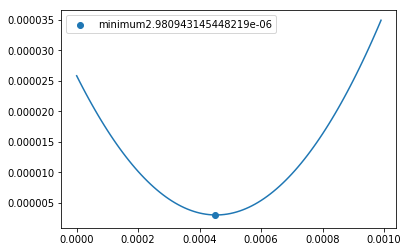

0.00045000000000000004


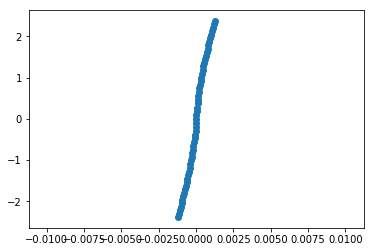

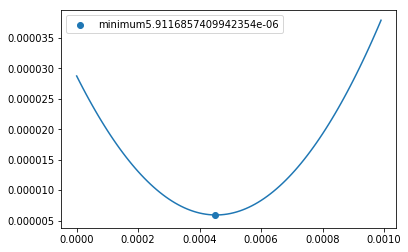

0.00045000000000000004


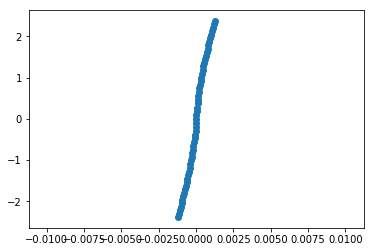

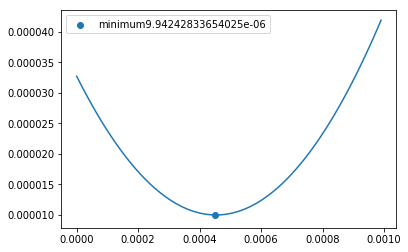

0.00045000000000000004


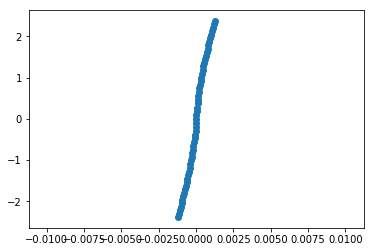

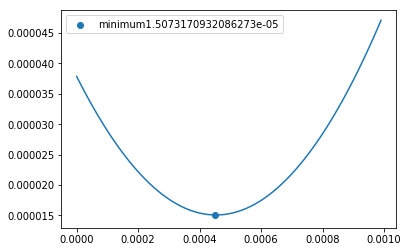

0.00045000000000000004


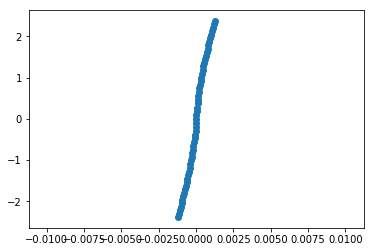

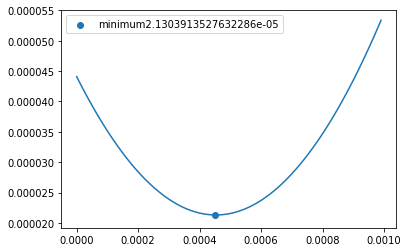

0.00045000000000000004


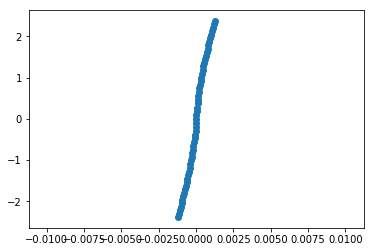

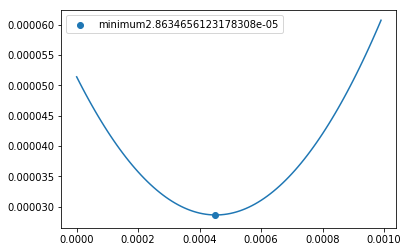

0.00045000000000000004


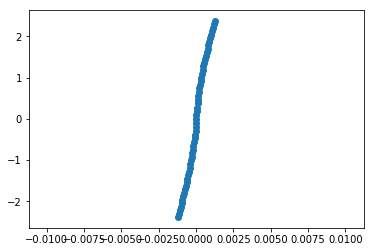

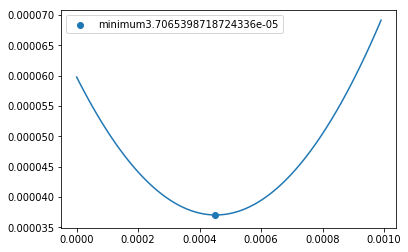

0.00045000000000000004


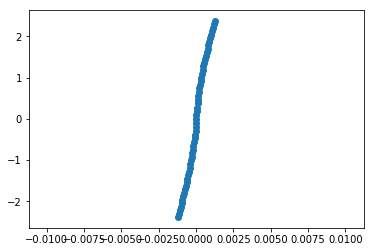

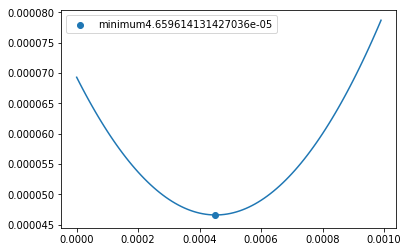

0.00045000000000000004


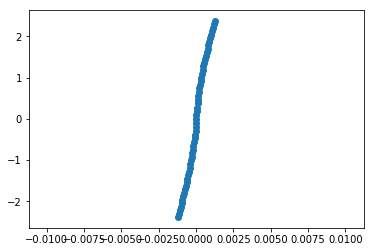

In [129]:
start = 0
end = 0.001
step = 0.00001



file = open('min_score_log.txt', 'a')

minresists = []
xoffsets = []
bestscores = []

for xoffset in np.arange(-0.001, 0.001, 0.0001):
    counts = []
    resists = []
    threshold = 0.005
    points = []
    Is = []
    scores = []
    Voltages = []
    
    for resist in np.arange(start,end,step):
        #plt.figure(figsize=(10,10))
        #plt.grid()
        #plt.axis([-.1,.1,-3,3])
        V_bias = []
        count = 0
        for index in range(len(TEStr.rawIV[0])):
                    V_bias.append((TEStr.rawIV[0][index] * R_shunt) - (TEStr.I_TES[index]*(R_shunt + resist)))
        entriesV = []
        entriesI = []
        score = 0
        
        if xoffset > 0:
            for i in range(len(V_bias)):
                if V_bias[i] <= xoffset + threshold and V_bias[i] >= xoffset - threshold:
                    count += 1
                    entriesV.append(V_bias[i])
                    entriesI.append(TEStr.I_TES[i])
                    score += abs(V_bias[i] + xoffset)**2
        elif xoffset == 0:
            for i in range(len(V_bias)):
                if abs(V_bias[i]) <= threshold:
                    count += 1
                    entriesV.append(V_bias[i])
                    entriesI.append(TEStr.I_TES[i])
                    score += abs(V_bias[i])**2
        else:
            for i in range(len(V_bias)):
                if V_bias[i] >= xoffset - threshold and V_bias[i] <= xoffset + threshold:
                    count += 1
                    entriesV.append(V_bias[i])
                    entriesI.append(TEStr.I_TES[i])
                    score += abs(V_bias[i] - xoffset)**2
            
        Voltages.append(V_bias)
        scores.append(score)
        counts.append(count)
        resists.append(resist)
        points.append(entriesV)
        Is.append(entriesI)
    
    idx = np.argmin(scores)
    plt.plot(resists, scores)
    plt.scatter(resists[idx],scores[idx], label='minimum' + str(scores[idx]))
    plt.legend()
    plt.show()
    print(resists[np.argmin(scores)])
    plt.scatter(points[np.argmin(score)], Is[np.argmin(score)])
    plt.show()
    bestscores.append(min(scores))
    
    minresists.append(resists[np.argmin(scores)])
    xoffsets.append(xoffset)


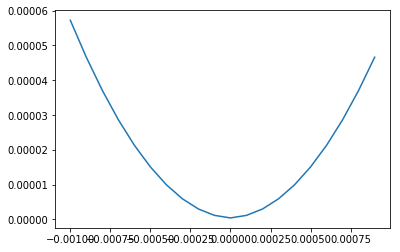

In [130]:
plt.plot(xoffsets,bestscores)

In [133]:
print(xoffsets[np.argmin(bestscores)])

4.336808689942018e-19


In [141]:
print(np.argmin(bestscores))

10
